In [69]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import  plot_acf, plot_pacf
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

from datetime import datetime, timedelta


import sys
import os

sys.path.append(os.path.abspath('..'))
from utils.db import get_db
from utils import find_missing_dates
from utils.fill_dates import fill_missing_dates

In [41]:
engine = get_db()

In [42]:
yesterday = datetime.now() - timedelta(days=1)
print(f"Yesterday: {yesterday.strftime('%m-%d-%Y')}")   

Yesterday: 06-07-2025


In [43]:
end_date = yesterday

In [44]:
query = f"""
select sale_date, sum(total_sales) as sales
    from sales
    where store_number='440'
    and sale_type in ('Refunded', 'Sale')
    and item_ring_type in ('ITEM', 'SUBD')
    and sale_date between '1/1/2024' and '{end_date}'
group by sale_date
order by sale_date

"""

In [45]:
ds = pd.read_sql(query,engine)

2025-06-08 18:38:34,332 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2025-06-08 18:38:34,333 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-08 18:38:34,389 INFO sqlalchemy.engine.Engine select current_schema()
2025-06-08 18:38:34,389 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-08 18:38:34,445 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2025-06-08 18:38:34,445 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-06-08 18:38:34,509 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-06-08 18:38:34,510 INFO sqlalchemy.engine.Engine SELECT pg_catalog.pg_class.relname 
FROM pg_catalog.pg_class JOIN pg_catalog.pg_namespace ON pg_catalog.pg_namespace.oid = pg_catalog.pg_class.relnamespace 
WHERE pg_catalog.pg_class.relname = %(table_name)s AND pg_catalog.pg_class.relkind = ANY (ARRAY[%(param_1)s, %(param_2)s, %(param_3)s, %(param_4)s, %(param_5)s]) AND pg_catalog.pg_table_is_visible(pg_catalog.pg_class.oid) AND pg_catalog.pg_namespace.nspname != %(nspname

In [46]:
ds.head()

,sale_date,sales
0,2024-02-22,26663.38
1,2024-02-23,32014.73
2,2024-02-24,27218.10
3,2024-02-25,32889.18
4,2024-02-26,24462.87


In [47]:
start_date = ds['sale_date'].min()
end_date = ds['sale_date'].max()

In [48]:
missing = find_missing_dates(ds, 'sale_date', start_date=start_date, end_date=end_date)
print(missing)

[Timestamp('2025-04-11 00:00:00')]


In [49]:
# backup my main man ds
ds_backup = ds.copy()

In [50]:
ds = fill_missing_dates(ds, 'sale_date', 'sales', start_date, end_date, 0)

In [51]:
ds.head()

,sale_date,sales
0,2024-02-22,26663.38
1,2024-02-23,32014.73
2,2024-02-24,27218.10
3,2024-02-25,32889.18
4,2024-02-26,24462.87


In [61]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      472 non-null    datetime64[ns]
 1   y       472 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.5 KB


In [53]:
ds = ds.rename(columns={'sale_date': 'ds', 'sales': 'y'})

In [60]:
ds.head()

,ds,y
0,2024-02-22,26663.38
1,2024-02-23,32014.73
2,2024-02-24,27218.10
3,2024-02-25,32889.18
4,2024-02-26,24462.87


In [57]:
ds['ds'] = pd.to_datetime(ds['ds'], format='%m/%d/%Y')

In [63]:
def plot(title, data, x, y, x_label, y_label, hover_data=None):
    """ General function to plot data"""
    fig = px.line(
        data, 
        x=data[x], 
        y=data[y], 
        title=title,
        labels={x: x_label, y: y_label},
        hover_data=hover_data
        #hover_data={'sale_date': True, 'sales': True, 'day_of_week': True}
        )

    fig.update_layout(
        template='simple_white',
        font=dict(size=16),
        width=1400,
        height=450,
        title_x=0.5,
        xaxis=dict(
            tickangle=-45,
            tickformat="%b %d",
            showgrid=True,
            rangeselector=dict(
                buttons=list([
                    dict(count=7, label="1w", step="day", stepmode="backward"),
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(visible=True),
            type="date"
        ),
        yaxis=dict(showgrid=True)
    )
    
    fig.show()

In [64]:
plot('Sales', ds, 'ds', 'y', 'Date', 'Sales')

i:\Code_maths\env\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


## Seasonal decomposition

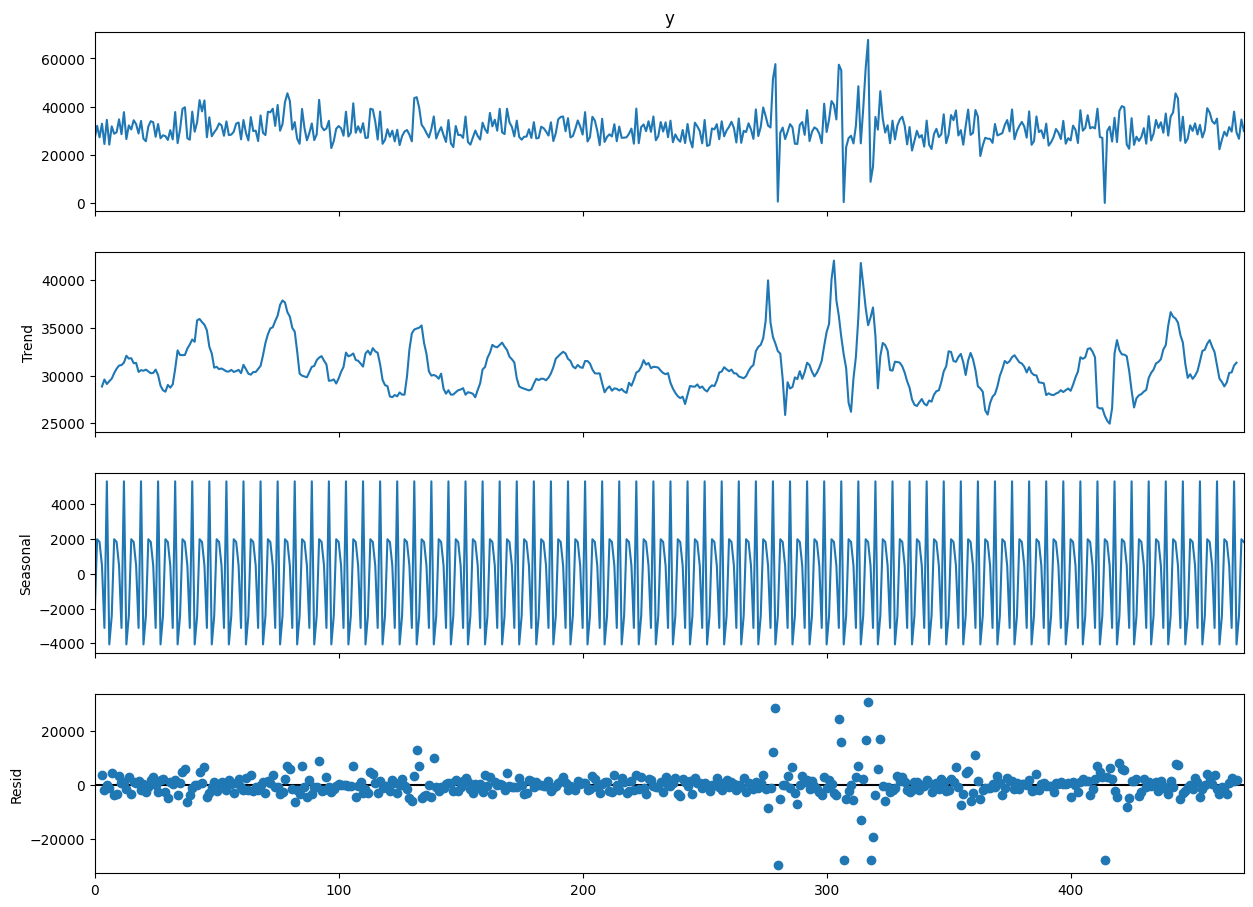

In [87]:
decomposition = seasonal_decompose(ds['y'], model='additive', period=7)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

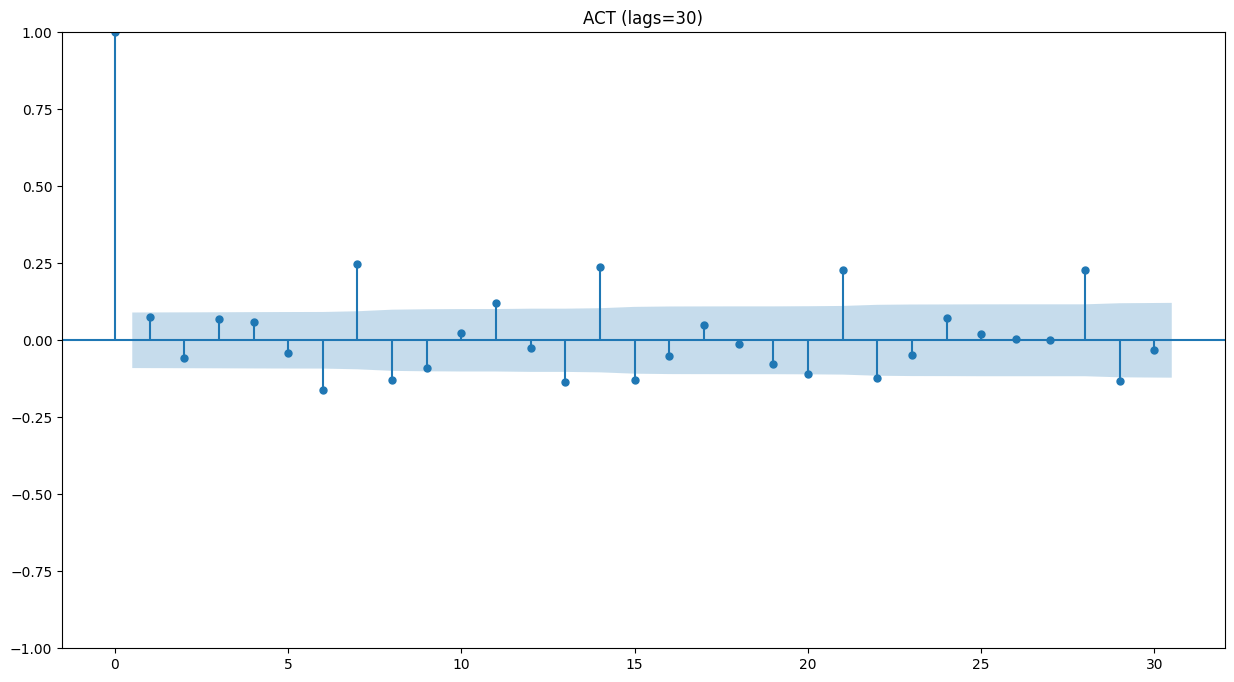

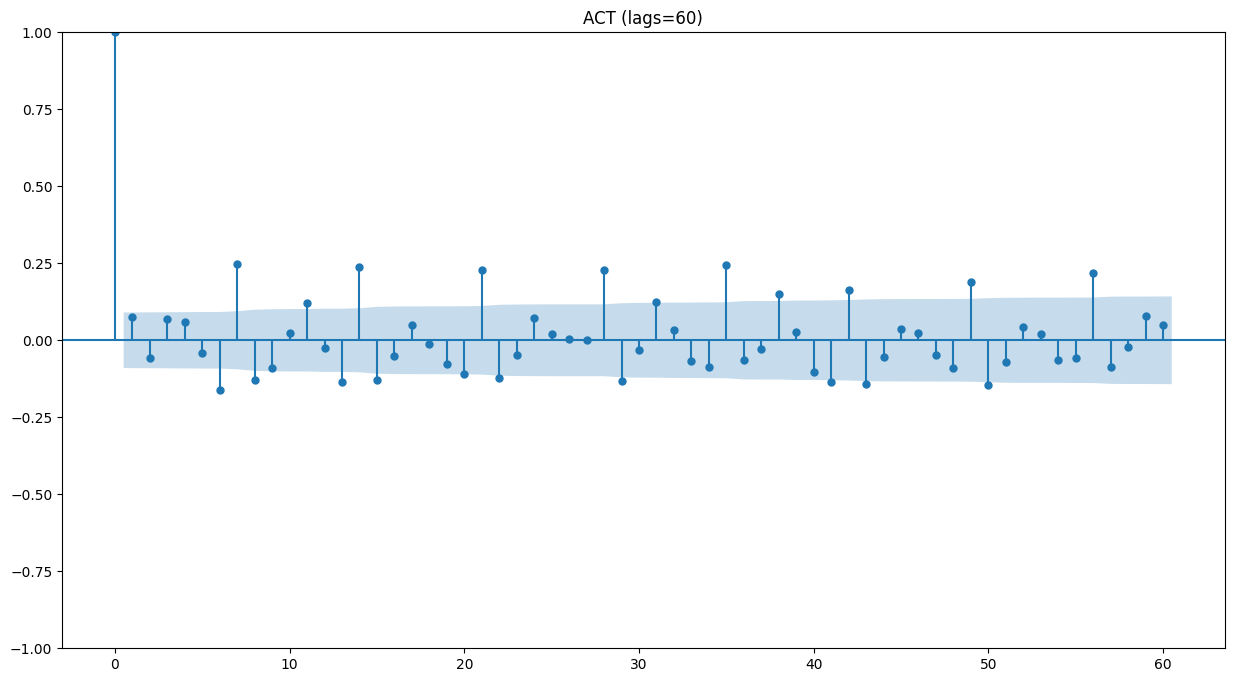

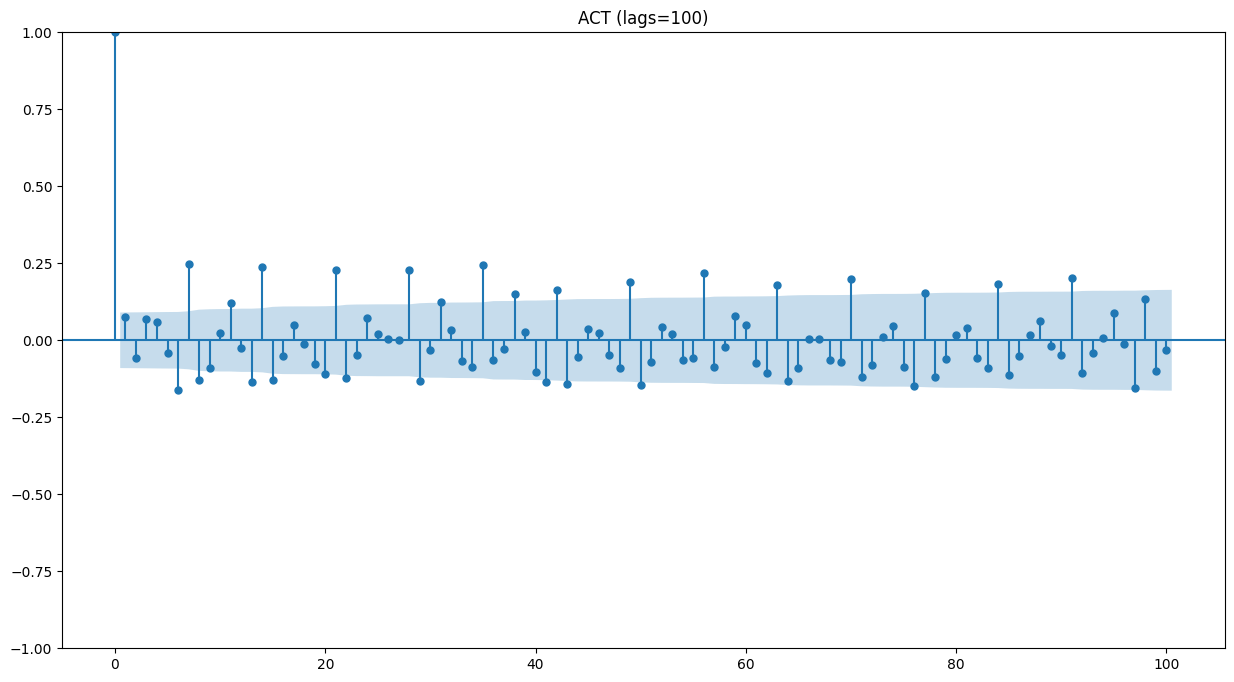

In [71]:
for n_lags in (30, 60, 100):
    fig, ax = plt.subplots(figsize=(15, 8))
    plot_acf(ds['y'], lags=n_lags, ax=ax)
    plt.title(f'ACT (lags={n_lags})')
    plt.show()

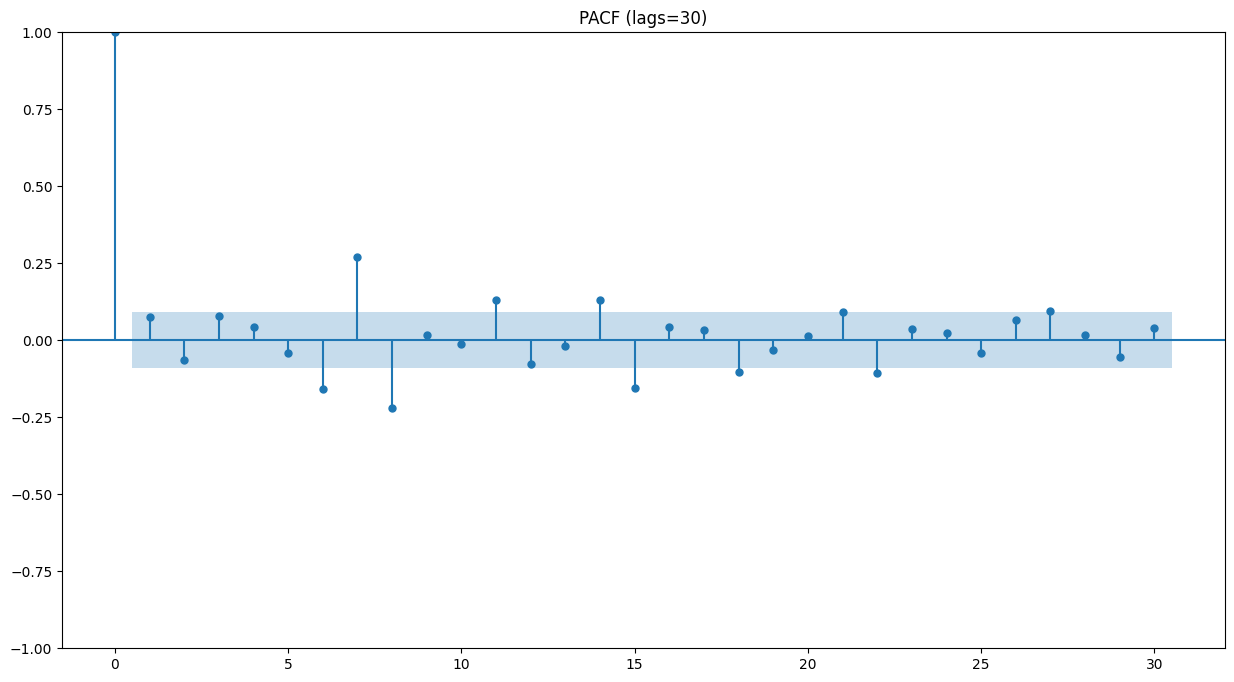

In [72]:
# plot the pacf
fig, ax = plt.subplots(figsize=(15, 8))
plot_pacf(ds['y'], lags=30, ax=ax)
plt.title('PACF (lags=30)')
plt.show()

In [73]:
xmas = pd.DataFrame({'holiday': 'christmas',
                     'ds': pd.to_datetime(['2022-12-25', '2023-12-25', '2024-12-25']),
                    'lower_window': -2,
                    'upper_window': 2})

nye = pd.DataFrame({'holiday': 'new_years',
                    'ds': pd.to_datetime(['2022-12-31', '2023-12-31', '2024-12-31']),
                    'lower_window': -2,
                    'upper_window': 2})

easter = pd.DataFrame({'holiday': 'easter',
                       'ds': pd.to_datetime(['2022-01-17', '2023-04-09', '2024-03-31', '2025-04-20']),
                       'lower_window': -2,
                       'upper_window': 2})

fourth_of_july = pd.DataFrame({'holiday': 'forth_of_july',
                               'ds': pd.to_datetime(['2022-06-04', '2023-07-04', '2024-07-04']),
                               'lower_window': -3,
                               'upper_window': 3})

superbowl = pd.DataFrame({'holiday': 'superbowl', 
                          'ds': pd.to_datetime(['2022-02-13', '2023-02-12', '2024-02-11', '2025-02-09' ]),
                          'lower_window': -2,
                          'upper_window': 2})

college_football = pd.DataFrame({'holiday': 'college_football', 
                                 'ds': pd.to_datetime(['2022-01-10', '2023-01-09', '2024-01-08', '2025-01-20']),
                                 'lower_window': -2,
                                 'upper_window': 2})

thanksgiving = pd.DataFrame({'holiday': 'thanksgiving', 
                                 'ds': pd.to_datetime(['2022-01-10', '2023-01-09', '2024-01-08', '2025-01-20']),
                                 'lower_window': -2,
                                 'upper_window': 2})

memorial_day = pd.DataFrame({'holiday': 'memorial_day', 
                                 'ds': pd.to_datetime(['2022-05-30', '2023-05-29', '2024-05-27', '2025-05-26']),
                                 'lower_window': -2,
                                 'upper_window': 2})
labor_day = pd.DataFrame({'holiday': 'labor_day', 
                                 'ds': pd.to_datetime(['2022-09-05', '2023-09-04', '2024-09-02', '2025-09-01']),
                                 'lower_window': -2,
                                 'upper_window': 2})

halloween = pd.DataFrame({'holiday': 'halloween', 
                                 'ds': pd.to_datetime(['2022-10-31', '2023-10-31', '2024-10-31', '2025-10-31']),
                                 'lower_window': -3,
                                 'upper_window': 3})
# march_madness ??? too many dates

xtra = pd.DataFrame({'holiday': 'halloween', 
                                 'ds': pd.to_datetime(['2022-12-21']),
                                 'lower_window': -2,
                                 'upper_window': 2})

In [74]:
# combine all the holidays into one dataset
holidays = pd.concat([xmas, nye, easter, fourth_of_july, superbowl, college_football, thanksgiving, memorial_day, labor_day, halloween, xtra])

In [76]:
holidays.to_pickle('holidays.pkl')

## Prophet model

In [77]:
from prophet import Prophet

In [79]:
ds['ds'].max()

Timestamp('2025-06-07 00:00:00')

In [82]:
train = ds[:-14]
train['ds'].min(), train['ds'].max()

(Timestamp('2024-02-22 00:00:00'), Timestamp('2025-05-24 00:00:00'))

In [81]:
test = ds[-14:]
test['ds'].min(), test['ds'].max()

(Timestamp('2025-05-25 00:00:00'), Timestamp('2025-06-07 00:00:00'))

In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458 entries, 0 to 457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      458 non-null    datetime64[ns]
 1   y       458 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.3 KB


In [89]:
model = Prophet(
    holidays=holidays,
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
)

In [90]:
model.fit(train)

19:22:15 - cmdstanpy - INFO - Chain [1] start processing
19:22:15 - cmdstanpy - INFO - Chain [1] done processing


## Cross Validation

In [91]:
from prophet.diagnostics import cross_validation

In [92]:
train.shape

(458, 2)

In [95]:
ds_cv = cross_validation(model=model, initial='180 days', period='7 days', horizon='14 days', parallel="processes")

In [96]:
ds_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2024-08-25,30907.441621,26544.130392,34705.928876,29660.55,2024-08-24
1,2024-08-26,26062.941511,21990.452124,30217.890920,27967.58,2024-08-24
2,2024-08-27,33491.802958,29669.851837,37659.701388,33465.50,2024-08-24
3,2024-08-28,25921.092395,21884.250743,30082.633560,25681.51,2024-08-24
4,2024-08-29,26404.334298,22254.671009,30528.567050,28970.68,2024-08-24


In [97]:
from prophet.diagnostics import performance_metrics

In [118]:
ds_metrics = performance_metrics(ds_cv)

In [119]:
ds_metrics['mape'] = np.abs((ds_cv['y'] - ds_cv['yhat']) / ds_cv['y']) * 100
metrics = ds_metrics.replace([np.inf, -np.inf], np.nan)
#metrics = metrics.dropna(subset=['mape'])


In [120]:
metrics

,horizon,mse,rmse,mae,mdape,smape,coverage,mape
0,2 days,3.699179e+07,6082.087986,3330.228046,0.069494,0.114110,0.879841,4.203872
1,3 days,3.219071e+07,5673.685695,3509.315131,0.073568,0.099682,0.838133,6.810166
2,4 days,4.738396e+07,6883.600490,3604.889583,0.075698,0.133656,0.872393,0.078597
3,5 days,4.550954e+07,6746.075598,4023.874422,0.095026,0.162539,0.781529,0.932898
4,6 days,5.566287e+07,7460.755306,4836.391422,0.115032,0.176038,0.717974,8.858424
5,7 days,5.360597e+07,7321.609833,4290.213476,0.078006,0.131502,0.748262,6.980082
6,8 days,3.460425e+07,5882.537628,3450.534700,0.056067,0.112668,0.819762,14.400796
7,9 days,3.612673e+07,6010.551550,3391.581308,0.077507,0.116515,0.860973,14.301753
8,10 days,3.411022e+07,5840.395527,3613.631811,0.066873,0.102843,0.811817,12.905301
9,11 days,4.917276e+07,7012.329444,3767.130086,0.073418,0.139629,0.827210,5.269271


In [124]:
rmse = metrics['rmse'].mean()
mape = metrics['mape'].mean()

In [125]:
rmse, mape

(np.float64(6657.815000427976), np.float64(6.92505226124111))

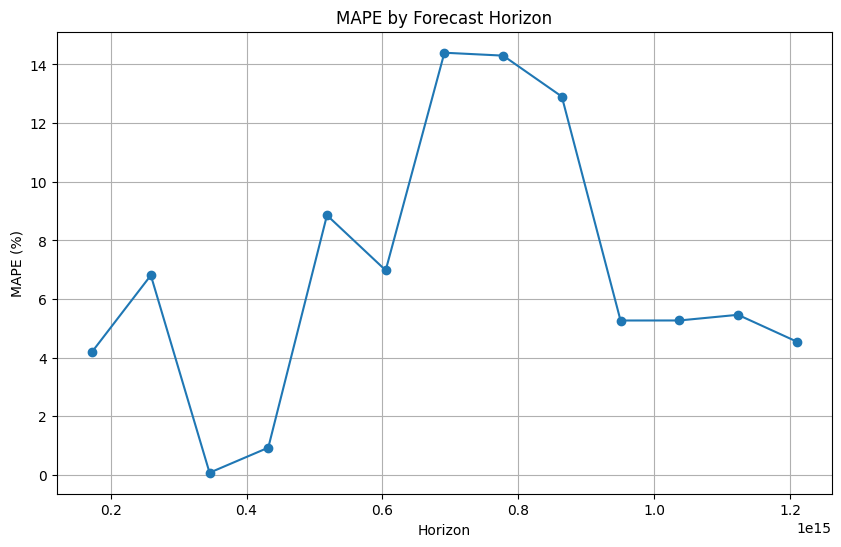

In [123]:
metrics_grouped = metrics.groupby('horizon')['mape'].mean()
plt.figure(figsize=(10, 6))
plt.plot(metrics_grouped.index, metrics_grouped.values, marker='o')
plt.xlabel('Horizon')
plt.ylabel('MAPE (%)')
plt.title('MAPE by Forecast Horizon')
plt.grid(True)
plt.show()

In [126]:
ds_cv['deviation'] = ds_cv['yhat'] - ds_cv['y']

In [128]:
ds_cv.sort_values(by='deviation', ascending=True).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,deviation
258,2025-01-04,32437.868474,27540.257820,37616.724797,67693.14,2024-12-28,-35255.271526
251,2025-01-04,32749.575821,27697.969579,38034.746922,67693.14,2024-12-21,-34943.564179
178,2024-11-27,25476.152154,21659.379879,29261.601278,57635.31,2024-11-16,-32159.157846
185,2024-11-27,26234.598037,22555.642323,30225.723362,57635.31,2024-11-23,-31400.711963
232,2024-12-23,26955.854367,21558.906045,32115.442296,57393.22,2024-12-14,-30437.365633
239,2024-12-23,27878.397189,23003.537369,33316.415032,57393.22,2024-12-21,-29514.822811
257,2025-01-03,33629.888816,28278.177214,38682.839701,55824.98,2024-12-28,-22195.091184
250,2025-01-03,33804.329236,28586.136137,38757.019415,55824.98,2024-12-21,-22020.650764
233,2024-12-24,35104.187667,30003.116353,40416.865112,55054.98,2024-12-14,-19950.792333
240,2024-12-24,36256.890388,31230.383308,41364.268944,55054.98,2024-12-21,-18798.089612


## Parameter tuning

In [129]:
param_grid = {
    'changepoint_prior_scale': [0.05, 0.5],
    'seasonality_prior_scale': [10,15, 20],
    'holidays_prior_scale': [10, 15, 20],
    'seasonality_mode': ['additive', 'multiplicative']
}

In [130]:
all_params = list(ParameterGrid(param_grid))

In [131]:
len(all_params)

36

In [132]:
tuning_result = []

In [134]:
for params in all_params:
    model = Prophet(
        holidays=holidays,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode=params['seasonality_mode'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        changepoint_prior_scale=params['changepoint_prior_scale']        
    )
    model.fit(train)
    ds_cv = cross_validation(
        model=model,
        initial='180 days',
        period='7 days',
        horizon='14 days',
        parallel="processes"
    )
    ds_metrics = performance_metrics(ds_cv)
    ds_metrics['mape'] = np.abs((ds_cv['y'] - ds_cv['yhat']) / ds_cv['y']) * 100
    metrics = ds_metrics.replace([np.inf, -np.inf], np.nan)
    mape = metrics['mape'].mean()
    tuning_result.append(mape)

19:57:39 - cmdstanpy - INFO - Chain [1] start processing
19:57:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:57:42 - cmdstanpy - INFO - Chain [1] start processing
19:57:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:57:44 - cmdstanpy - INFO - Chain [1] start processing
19:57:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:57:47 - cmdstanpy - INFO - Chain [1] start processing
19:57:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:57:50 - cmdstanpy - INFO - Chain [1] start processing
19:57:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has per

In [135]:
outcome = pd.DataFrame(all_params)
outcome['tuning_results'] = tuning_result
outcome

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,tuning_results
0,0.05,10,additive,10,45.183252
1,0.05,10,additive,15,138.637325
2,0.05,10,additive,20,12.342750
3,0.05,10,multiplicative,10,10.552889
4,0.05,10,multiplicative,15,141.300699
5,0.05,10,multiplicative,20,118.607842
6,0.05,15,additive,10,11.874096
7,0.05,15,additive,15,71.770945
8,0.05,15,additive,20,80.048604
9,0.05,15,multiplicative,10,15.951945


In [142]:
min = outcome['tuning_results'].min()
outcome[outcome['tuning_results'] == min]

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,tuning_results
3,0.05,10,multiplicative,10,10.552889


In [143]:
model = Prophet(
    holidays=holidays,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    changepoint_prior_scale=0.05        
)
model.fit(train)

20:04:12 - cmdstanpy - INFO - Chain [1] start processing
20:04:12 - cmdstanpy - INFO - Chain [1] done processing


## Forecasting

In [149]:
train.tail()

,ds,y
453,2025-05-20,32392.98
454,2025-05-21,27159.36
455,2025-05-22,30171.16
456,2025-05-23,39333.42
457,2025-05-24,37506.82


In [153]:
future = model.make_future_dataframe(periods=14, freq='D')
future.tail()

,ds
467,2025-06-03
468,2025-06-04
469,2025-06-05
470,2025-06-06
471,2025-06-07


In [154]:
forecast = model.predict(future)
forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,christmas,christmas_lower,christmas_upper,college_football,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
467,2025-06-03,29732.629402,28273.494350,39695.519410,29732.441977,29732.862882,0.0,0.0,0.0,0.0,...,0.165108,0.165108,0.165108,-0.021630,-0.021630,-0.021630,0.0,0.0,0.0,33998.625431
468,2025-06-04,29728.997784,20020.269607,31472.118316,29728.740613,29729.281248,0.0,0.0,0.0,0.0,...,-0.110762,-0.110762,-0.110762,-0.022771,-0.022771,-0.022771,0.0,0.0,0.0,25759.195720
469,2025-06-05,29725.366165,21368.763186,32519.693173,29725.053154,29725.711119,0.0,0.0,0.0,0.0,...,-0.078017,-0.078017,-0.078017,-0.022986,-0.022986,-0.022986,0.0,0.0,0.0,26723.005542
470,2025-06-06,29721.734547,25350.975003,37353.210019,29721.379684,29722.143627,0.0,0.0,0.0,0.0,...,0.066193,0.066193,0.066193,-0.022347,-0.022347,-0.022347,0.0,0.0,0.0,31024.898523
471,2025-06-07,29718.102929,24969.512135,36096.686590,29717.701056,29718.575372,0.0,0.0,0.0,0.0,...,0.048819,0.048819,0.048819,-0.020950,-0.020950,-0.020950,0.0,0.0,0.0,30546.319445


In [155]:
forecast_predictions = forecast[['ds', 'yhat']].copy()

In [156]:
forecast_predictions.tail()

,ds,yhat
467,2025-06-03,33998.625431
468,2025-06-04,25759.195720
469,2025-06-05,26723.005542
470,2025-06-06,31024.898523
471,2025-06-07,30546.319445


In [157]:
test

,ds,y
458,2025-05-25,33920.51
459,2025-05-26,32869.06
460,2025-05-27,35001.52
461,2025-05-28,22282.95
462,2025-05-29,26223.66
463,2025-05-30,29574.71
464,2025-05-31,27829.92
465,2025-06-01,31503.63
466,2025-06-02,29610.13
467,2025-06-03,37911.98


In [158]:
merged = test.merge(
    forecast_predictions,
    on='ds',
    how='left'
)
merged

,ds,y,yhat
0,2025-05-25,33920.51,29157.477526
1,2025-05-26,32869.06,29974.296114
2,2025-05-27,35001.52,32830.625752
3,2025-05-28,22282.95,22001.451174
4,2025-05-29,26223.66,27387.671234
5,2025-05-30,29574.71,31498.652632
6,2025-05-31,27829.92,30828.674599
7,2025-06-01,31503.63,29922.633371
8,2025-06-02,29610.13,25768.861423
9,2025-06-03,37911.98,33998.625431


In [165]:
merged['diff'] = merged['y'] - merged['yhat']
merged['abs_error'] = merged['diff'].abs()
merged['pct_error'] = merged['diff'] / merged['y'] * 100
merged['mape'] = merged['abs_error'] / merged['y'] * 100
merged['squared_error'] = merged['diff'] ** 2

In [166]:
merged

,ds,y,yhat,diff,abs_error,pct_error,mape,squared_error
0,2025-05-25,33920.51,29157.477526,4763.032474,4763.032474,14.041748,14.041748,2.268648e+07
1,2025-05-26,32869.06,29974.296114,2894.763886,2894.763886,8.806957,8.806957,8.379658e+06
2,2025-05-27,35001.52,32830.625752,2170.894248,2170.894248,6.202286,6.202286,4.712782e+06
3,2025-05-28,22282.95,22001.451174,281.498826,281.498826,1.263292,1.263292,7.924159e+04
4,2025-05-29,26223.66,27387.671234,-1164.011234,1164.011234,-4.438783,4.438783,1.354922e+06
5,2025-05-30,29574.71,31498.652632,-1923.942632,1923.942632,-6.505364,6.505364,3.701555e+06
6,2025-05-31,27829.92,30828.674599,-2998.754599,2998.754599,-10.775290,10.775290,8.992529e+06
7,2025-06-01,31503.63,29922.633371,1580.996629,1580.996629,5.018459,5.018459,2.499550e+06
8,2025-06-02,29610.13,25768.861423,3841.268577,3841.268577,12.972819,12.972819,1.475534e+07
9,2025-06-03,37911.98,33998.625431,3913.354569,3913.354569,10.322211,10.322211,1.531434e+07


In [167]:
mae = merged['abs_error'].mean()
mape = merged['mape'].mean()
mae, mape

(np.float64(2387.1484583390534), np.float64(7.5267701326393945))

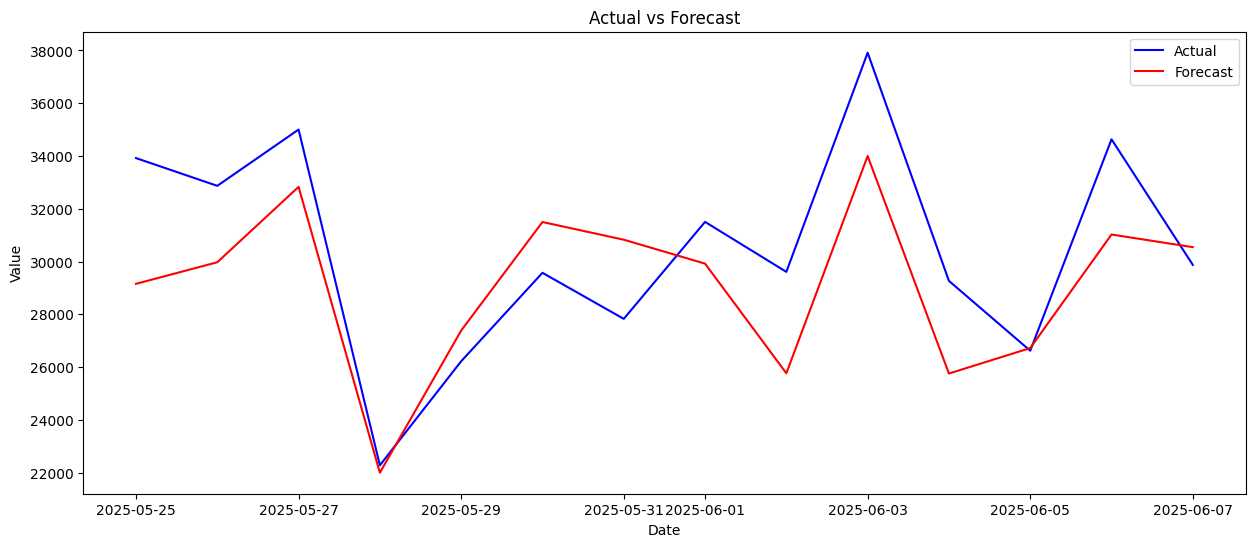

In [169]:
# Visualize time series plot
plt.figure(figsize=(15, 6))
# Plot actual and forecasted values
plt.plot(merged['ds'], merged['y'], label='Actual', color='blue')
plt.plot(merged['ds'], merged['yhat'], label='Forecast', color='red')
# Fill the uncertainty interval (between yhat_lower and yhat_upper) with a pink color
#plt.fill_between(merged['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='pink', alpha=0.3)
# add title, xlabel, ylabel, legend
plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [170]:
from prophet.serialize import model_to_json
with open('store_440_prophet.json', 'w') as fout:
    fout.write(model_to_json(model))